# predict with NLP

In [5]:
RAND_SEED=789
#configure for local eicu databse
exec(open("/Users/grovesdixon/gitreps/Insight_fellowship_project/merge/configure_eicu.py").read())
exec(open("my_functions.py").read())

Database: eicu
Username: postgres

Configured for local EICU database.


### load data

In [48]:
with_nlp = pd.read_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/with_nlp.csv')
with_nlp.index = with_nlp['HADM_ID']

### prepare for modeling

In [49]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
y = with_nlp['outcome']
X = with_nlp.drop(['outcome',
                   'HADM_ID',
                   'SUBJECT_ID'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=456, stratify = y)

### optimize random forest for data with NLP

In [50]:
#------- OPTIMIZE RF

#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [25, 50, 100, 150]
min_samples_split = [2, 4, 8]
min_samples_leaf = [1, 3, 5]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# ### run random search
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'recall',
                               cv = 5,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = 3)
rf_search.fit(X_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

### or just enter them

In [51]:
#best_params = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 150} #STORED
best_params = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}

In [52]:
#set up optimized rf model based on from best_params above
rf_opt = RandomForestClassifier(n_jobs=4,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=789, verbose=0,
                       warm_start=False)

### training performance for optimized RF on data with NLP

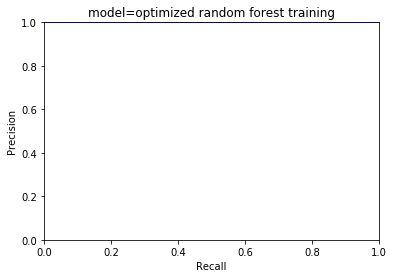

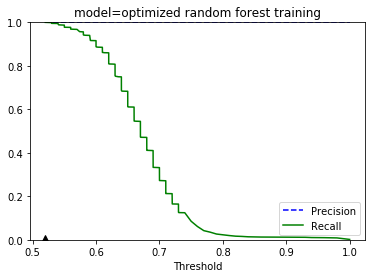

Confusion matrix for threshold = 0.52:
[[32991     0]
 [    2  1733]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32991
           1       1.00      1.00      1.00      1735

    accuracy                           1.00     34726
   macro avg       1.00      1.00      1.00     34726
weighted avg       1.00      1.00      1.00     34726



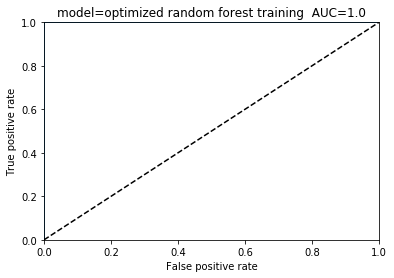

In [53]:
#optimized model performance on training set
probs_opt_t = rf_opt.predict_proba(X_train)
scores_opt_t = probs_opt_t[:, 1]
opt_perf_t = get_model_performance('optimized random forest training', X_train, scores_opt_t, y_train, pos_label=1)

### test performance

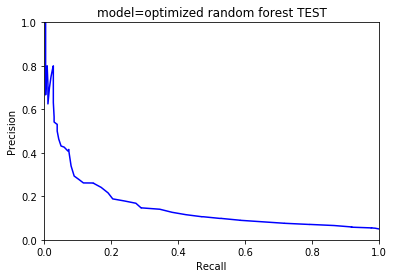

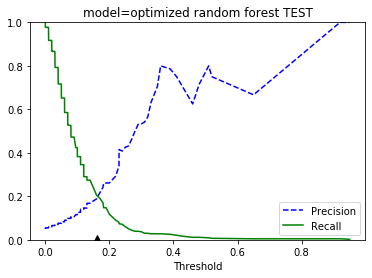

Confusion matrix for threshold = 0.16:
[[7946  302]
 [ 351   83]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8248
           1       0.22      0.19      0.20       434

    accuracy                           0.92      8682
   macro avg       0.59      0.58      0.58      8682
weighted avg       0.92      0.92      0.92      8682



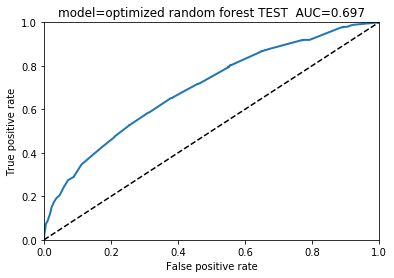

Confusion matrix for threshold = 0.07:
[[6141 2107]
 [ 205  229]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      8248
           1       0.10      0.53      0.17       434

    accuracy                           0.73      8682
   macro avg       0.53      0.64      0.50      8682
weighted avg       0.92      0.73      0.81      8682



In [54]:
#predict for test set
test_probs = rf_opt.predict_proba(X_test)
test_scores = test_probs[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.07
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))

# output results for app

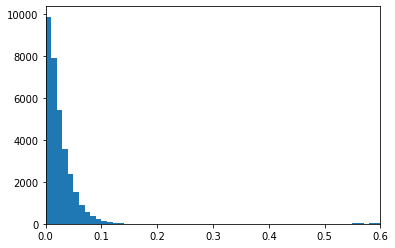

acid                  int64
active                int64
adhere                int64
admissions            int64
aerosol               int64
                     ...   
DRUG_CefePIME         int64
DRUG_Nephrocaps       int64
DRUG_Labetalol        int64
prob_readmission    float64
HADM_ID               int64
Length: 326, dtype: object

In [69]:
#gather the results
res = X_train.copy()
res['prob_readmission'] = scores_opt_t
res
plt.hist(res['prob_readmission'], bins=100)
plt.xlim([0, 0.6])
plt.show()
min(res['prob_readmission'])
res['HADM_ID'] = res.index
res
res.dtypes

In [105]:
#pick a high ica stay
high = res.loc[(res['prob_readmission'] > 0.8) & (res['prob_readmission'] < 0.94)].sort_values('prob_readmission', ascending = False)
high.index = range(len(high.index))
h = high.loc[0,:]
h

#pick a medium
med = res.loc[(res['prob_readmission'] > 0.4),].sort_values('prob_readmission', ascending = True)
med.index = range(len(med.index))
m = med.loc[5,:]

#low
low = res.loc[(res['prob_readmission'] > 0.1),].sort_values('prob_readmission', ascending = True)
low.index = range(len(low.index))
l = low.loc[5,:]
l

#vlow
low = res.loc[(res['prob_readmission'] > 0.005),].sort_values('prob_readmission', ascending = True)
low.index = range(len(low.index))
vl = low.loc[5,:]
vl

#show sex
print(example_patients['GENDER_M'])

#show example
example_patients = pd.DataFrame([h,m,l,vl]).drop('prob_readmission', 1)
example_patients.index = ['June Hieghts', 'Jack Middleman', 'Jess Lowe', 'Joe V. Lowe']
example_patients.head()
example_patients['HADM_ID']

June Hieghts      0.0
Jack Middleman    1.0
Jess Lowe         0.0
Joe V. Lowe       1.0
Name: GENDER_M, dtype: float64


June Hieghts      172335.0
Jack Middleman    161839.0
Jess Lowe         163150.0
Joe V. Lowe       161562.0
Name: HADM_ID, dtype: float64

In [106]:
#upload prettier data
dat = pd.read_csv("/Users/grovesdixon/projects/Insight/icu_project/my_mimic/any_readmission_features.csv")
pa_column_list = ['diagnosis_icd9', 'procedure_icd9', 'DRUG']
standard_column_list = [i for i in dat.columns if i not in pa_column_list]
dat.index = dat['HADM_ID']
sdat = dat.loc[example_patients['HADM_ID'], standard_column_list].drop_duplicates()
sdat = sdat.drop(columns = ['outcome', 'SUBJECT_ID', 'HADM_ID'])
sdat.index = example_patients.index
example_patients = example_patients.loc[:, X_train.columns] #make sure example matches origina training set
sdat.head()

,INSURANCE,RELIGION,MARITAL_STATUS,hospital_duration,ADMISSION_LOCATION,DISCHARGE_LOCATION,GENDER,age,nicu_stays,total_icu_days,total_diagnoses,total_procedure,total_drug
June Hieghts,Medicaid,NOT SPECIFIED,SINGLE,6.139583,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,F,24.071242,1.0,2.041829,14,1,31.0
Jack Middleman,Medicare,NOT SPECIFIED,SINGLE,8.041667,PHYS REFERRAL/NORMAL DELI,SNF,M,72.521218,1.0,3.177442,9,7,46.0
Jess Lowe,Medicare,CATHOLIC,WIDOWED,12.881944,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,F,76.998994,1.0,4.116042,16,3,48.0
Joe V. Lowe,Medicare,OTHER,MARRIED,2.659028,CLINIC REFERRAL/PREMATURE,HOME,M,71.331366,1.0,1.296447,12,4,33.0


In [107]:
rf_opt.predict_proba(example_patients)[:, 1]

array([0.93, 0.53, 0.11, 0.01])

### output example data

In [109]:
sdat.to_csv('/Users/grovesdixon/gitreps/insight_webapp/data/readmission_example_patients_view.csv', index=True)
example_patients.to_csv('/Users/grovesdixon/gitreps/insight_webapp/data/readmission_example_patients.csv', index=True)

In [91]:
# save the model to disk
# import pickle
# filename = '../app/rf_model.sav'
# pickle.dump(rf_opt, open(filename, 'wb'))

from joblib import dump, load
dump(rf_opt, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/rf_model.joblib') 

['/Users/grovesdixon/projects/Insight/icu_project/my_mimic/rf_model.joblib']

In [110]:
sdat.columns

Index(['INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'hospital_duration',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'GENDER', 'age',
       'nicu_stays', 'total_icu_days', 'total_diagnoses', 'total_procedure',
       'total_drug'],
      dtype='object')

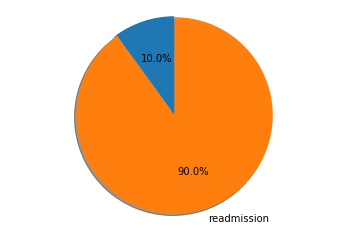

In [112]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['', 'readmission']
sizes = [10, 90]
explode = (0, 0.01)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()